<div style="text-align:center; background-color:#f0f0f0; padding:20px; border-radius:10px;">
    <h1 style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#333; font-size:3em; font-weight:bold;">Data-related Innovation in Finance</h1>
    <p style="font-family: 'Garamond', serif; font-size:1.5em; color:#555; margin-top:0;">Personal Analysis of Stocks & Cryptocurrencies</p>
    <p style="font-family: 'Arial', sans-serif; font-size:1.2em; color:#777; margin-top:0;">Authors: Antoine BUFFANDEAU - Mathieu GOURMELEN - Charles FRANÇOIS</p>
</div>

<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
The rendering (display/design) of this notebbok <b>doesn't function</b> properly on </b>Google Collab!</b>  
Please open it on Visual Studio Code for better rendering.

This notebook is public on <b>GitHub</b> at this link:  
  <a href="https://github.com/AntoineBuffandeau/Data_analysis_on_stocks" target="_blank" style="color: #007acc; font-weight: bold;">https://github.com/AntoineBuffandeau/Data_analysis_on_stocks</a>
</div>

<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466">

## TABLE OF CONTENTS

</div>

* [INTRODUCTION](#0)
* [PACKAGE IMPORTS](#1)
* [FUNCTIONS](#2)
* [Network Analysis of Stocks](#3)
    * [Data Collection and Preparation](#3a)
    * [Basic Analysis](#3b)
    * [Network Construction](#3c)
        * [2D representation](#3c1)
        * [3D representation](#3c2)
    * [Network Analysis](#3d)
        * [Network Metrics Analysis](#3d1)
        * [Network Centrality Measures Analysis](#3d2)
    * [Analysis on Network Models application (Erdős–Rényi and Barabási–Albert)](#3e)
    * [Meso-Scale Analysis (Community Detection and Core-Periphery)](#3f)
    * [Systemic Risk and Contagion Analysis (-> to erase maybe)](#3g)
    * [Portfolio Diversification](#3h)
    * [Report Findings](#3j)
* [Network Analysis of Cryptocurrencies](#4)
* [Modelling and Assessing Financial Contagion and Stability](#5)
* [CONCLUSION](#6)

<a id="0"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">INTRODUCTION<br></div>

["A review of two decades of correlations, hierarchies, networks and clustering in financial markets"](https://arxiv.org/abs/1703.00485)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">PACKAGE IMPORTS<br></div>

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go   #for 3D représentation of the network

from networkx.algorithms import community
from community import community_louvain 

In [37]:
print("Numpy version:",np.__version__)
print("Pandas version:", pd.__version__)
print("Yahoo Finance version:", yf.__version__)
print("NetWorkX:", nx.__version__)
print("Seaborn version:", sns.__version__)

Numpy version: 1.26.4
Pandas version: 2.2.1
Yahoo Finance version: 0.2.44
NetWorkX: 3.3
Seaborn version: 0.13.2


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">FUNCTIONS<br></div>

In [38]:
def plot_heatmap(matrix, title):
    """
    Plots a heatmap for a given matrix.

    Parameters:
    - matrix : pd.DataFrame or np.array
        -> The matrix to visualize, typically a correlation matrix.
    - title : str
        -> Title for the heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

def stronger_corr(matrix):
    """
    Identifies the top 10 strongest correlation pairs in a correlation matrix.

    Parameter:
    - matrix : pd.DataFrame
        -> A correlation matrix with stock tickers as both rows and columns.
    """
    corr_pairs = matrix.unstack()
    filtered_corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
    sorted_corr_pairs = filtered_corr_pairs.sort_values(ascending=False)
    top_10_correlations = sorted_corr_pairs.head(10)
    print("Top 10 strongest correlations:")
    print(top_10_correlations)

In [39]:
def plot_times_series(matrix):
    """
    Plots time series data for stock closing prices.

    Parameters:
    - matrix : pd.DataFrame
        -> DataFrame with time series data for stock prices, where each column represents a different stock and rows represent time.
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(matrix)

    #Formatting
    ax.set_title('Close Price (CAC40 Stocks)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Time (format \'yyyy\')', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Price (in EUR)', fontsize = 16, fontdict=dict(weight='bold'))

    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=16)
    ax.get_legend().set_visible(True)
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    plt.show()

def plot_trading_volumes(matrix):
    """
    Plots time series data for trading volumes.

    Parameters:
    - matrix : pd.DataFrame
        -> DataFrame with time series data for trading volumes, where each column represents a different stock and rows represent time.
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(matrix)

    # Formatting
    ax.set_title('Trading Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Time', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Trading Volume', fontsize = 16, fontdict=dict(weight='bold'))

    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=16)
    ax.get_legend().set_visible(True)
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [40]:
def create_correlation_network(correlation_matrix, threshold=0.5):
    """
    Creates a correlation network from a correlation matrix by adding edges between stocks with a correlation above a specified threshold.

    Parameters:
    - correlation_matrix : pd.DataFrame
        -> A correlation matrix where each row and column represent stocks.
    - threshold : float, optional
        -> The correlation threshold above which an edge is added between nodes. Default is 0.5.

    Returns:
    - G : networkx.Graph
        -> A NetworkX graph where nodes represent stocks and edges represent correlations above the specified threshold.
    """
    G = nx.Graph()
    G.add_nodes_from(correlation_matrix.columns)   #adding nodes for each stock in the correlation matrix

    #Iteration which adds an edge between the stocks if the correlation exceeds the threshold
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if correlation_matrix.iloc[i, j] > threshold:
                G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j],
                           weight=correlation_matrix.iloc[i, j])
                
    return G

def visualize_correlation_network(G, threshold, node_size=500, node_color="skyblue", edge_cmap=plt.cm.Blues, edge_vmin=0.5, edge_vmax=1):
    """
    Visualizes a correlation network with edges weighted by correlation values.

    Parameters:
    - G : networkx.Graph
        -> The correlation network graph.
    - threshold : float
        -> Correlation threshold value used to create the network.
    - node_size : int, optional
        -> Size of nodes in the plot (default: 500).
    - node_color : str, optional
        -> Color of the nodes (default: "skyblue").
    - edge_cmap : matplotlib.colors.Colormap, optional
        -> Colormap for edge colors based on weights (default: plt.cm.Blues).
    - edge_vmin : float, optional
        -> Minimum value for colormap normalization (default: 0.5).
    - edge_vmax : float, optional
        -> Maximum value for colormap normalization (default: 1).
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, ax=ax)

    edges = G.edges(data=True)
    edge_weights = [d['weight'] for (u, v, d) in edges]

    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_weights,
                           edge_cmap=edge_cmap, edge_vmin=edge_vmin, edge_vmax=edge_vmax, width=2, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", ax=ax)
    ax.set_title(f"Network of Stock Correlations (Threshold: {threshold})")
    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=edge_vmin, vmax=edge_vmax))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Correlation Strength')
    plt.show()

def visualize_correlation_network_3d(G, threshold, node_size=10, node_color="skyblue", edge_color="blue"):
    """
    Visualizes a 3D correlation network with edges weighted by correlation values.

    Parameters:
    - G : networkx.Graph
        -> The correlation network graph.
    - threshold : float
        -> Correlation threshold value used to create the network.
    - node_size : int, optional
        -> Size of nodes in the plot (default: 10).
    - node_color : str, optional
        -> Color of the nodes (default: "skyblue").
    - edge_color : str, optional
        -> Color of the edges (default: "blue").
    """
    pos = nx.spring_layout(G, dim=3, seed=42)  # Layout with 3D positioning
    edge_x = []
    edge_y = []
    edge_z = []
    edge_weights = []

    for edge in G.edges(data=True):
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
        edge_weights.append(edge[2]['weight'])

    # Nodes
    node_x = []
    node_y = []
    node_z = []
    for node in G.nodes():
        x, y, z = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)

    # Create figure
    fig = go.Figure()

    # Add edges as 3D lines
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color=edge_color, width=1),
        hoverinfo='none'
    ))

    # Add nodes as 3D scatter points
    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers+text',
        text=list(G.nodes),
        marker=dict(size=node_size, color=node_color),
    ))

    # Add layout properties
    fig.update_layout(
        title=f"3D Network of Stock Correlations (Threshold: {threshold})",
        scene=dict(
            xaxis=dict(title='X', showgrid=False, zeroline=False),
            yaxis=dict(title='Y', showgrid=False, zeroline=False),
            zaxis=dict(title='Z', showgrid=False, zeroline=False)
        )
    )

    fig.write_html("3d_correlation_network.html")


<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">Network Analysis of Stocks<br></div>

<a id="3a"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Import of historical data for CAC40 components from 2018 to 2023<br></div>

| Companies                        | Ticker Yahoo       | 2018 | 2019 | 2020 | 2021 | 2022 | 2023 | 2024 |
|------------------------------------|--------------------|------|------|------|------|------|------|------|
| Accor                              | AC.PA              | X    | X    | X    | X    | X    | X    | X    |
| Airbus                             | AIR.PA             | X    | X    | X    | X    | X    | X    | X    |
| Air Liquide                        | AI.PA              | X    | X    | X    | X    | X    | X    | X    |
| Alstom                             | ALO.PA             | X    | X    | X    | X    | X    | X    | X    |
| ArcelorMittal                      | MT.AS              | X    | X    | X    | X    |      |      |      |
| Atos                               | ATO.PA             | X    | X    | X    | X    |      |      |      |
| Axa                                | CS.PA              | X    | X    | X    | X    | X    | X    | X    |
| BNP Paribas                        | BNP.PA             | X    | X    | X    | X    | X    | X    | X    |
| Bouygues                           | EN.PA              | X    | X    | X    | X    | X    | X    | X    |
| Capgemini                          | CAP.PA             | X    | X    | X    | X    | X    | X    | X    |
| Carrefour                          | CA.PA              | X    | X    | X    | X    | X    | X    | X    |
| Crédit Agricole                    | ACA.PA             | X    | X    | X    | X    | X    | X    | X    |
| Danone                             | BN.PA              | X    | X    | X    | X    | X    | X    | X    |
| Dassault Systèmes                  | DSY.PA             | X    | X    | X    | X    | X    | X    | X    |
| Engie                              | ENGI.PA            | X    | X    | X    | X    | X    | X    | X    |
| Essilor/EssilorLuxottica           | EL.PA              | X    | X    | X    | X    | X    | X    | X    |
| Hermès                             | RMS.PA             | X    | X    | X    | X    | X    | X    | X    |
| Kering                             | KER.PA             | X    | X    | X    | X    | X    | X    | X    |
| L’Oréal                            | OR.PA              | X    | X    | X    | X    | X    | X    | X    |
| Legrand                            | LR.PA              | X    | X    | X    | X    | X    | X    | X    |
| LVMH                               | MC.PA              | X    | X    | X    | X    | X    | X    | X    |
| Michelin                           | ML.PA              | X    | X    | X    | X    | X    | X    | X    |
| Orange                             | ORA.PA             | X    | X    | X    | X    | X    | X    | X    |
| Pernod Ricard                      | RI.PA              | X    | X    | X    | X    | X    | X    | X    |
| Peugeot                            | UG.PA              | X    |      |      |      |      |      |      |
| Publicis                           | PUB.PA             | X    | X    | X    | X    | X    | X    | X    |
| Renault                            | RNO.PA             | X    | X    | X    | X    | X    | X    | X    |
| Safran                             | SAF.PA             | X    | X    | X    | X    | X    | X    | X    |
| Saint-Gobain                       | SGO.PA             | X    | X    | X    | X    | X    | X    | X    |
| Sanofi                             | SAN.PA             | X    | X    | X    | X    | X    | X    | X    |
| Schneider Electric                 | SU.PA              | X    | X    | X    | X    | X    | X    | X    |
| Société Générale                   | GLE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Solvay                             | SOLB.BR            | X    | X    |      |      |      |      |      |
| STMicroelectronics                 | STMPA.PA             | X    | X    | X    | X    | X    | X    | X    |
| TechnipFMC                         | FTI.PA             | X    | X    | X    |      |      |      |      |
| Thales                             | HO.PA              | X    | X    | X    | X    | X    | X    | X    |
| Total/TotalEnergies                | TTE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Unibail-Rodamco-Westfield          | URW.PA             | X    | X    | X    | X    | X    | X    | X    |
| Valeo                              | FR.PA              | X    | X    | X    | X    | X    | X    | X    |
| Veolia                             | VIE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Vinci                              | DG.PA              |      | X(N) | X    | X    | X    | X    | X    |
| Worldline                          | WLN.PA             |      |      | X(N) | X    | X    | X    | X    |
| Teleperformance                    | TEP.PA             |      |      | X(N) | X    | X    | X    | X    |
| Eurofins Scientific                | ERF.PA             |      |      |      | X(N) | X    | X    | X    |
| Stellantis                         | STLA.PA            |      |      |      |      | X(N) | X    | X    |


Comments : 

X : Indicates that the company was part of the CAC40 in that year ;

(N) : Indicates that a company entered the CAC40 for that year.

In [41]:
#I have arbitrarily chosen here to select only the stock names that remained in the CAC40 list from 2018 to 2023.
cac40_tickers = [
    'AC.PA',   # Accor
    'AI.PA',   # Air Liquide
    'AIR.PA',  # Airbus
    'ALO.PA',  # Alstom
    'BNP.PA',  # BNP Paribas
    'EN.PA',   # Bouygues
    'CAP.PA',  # Capgemini
    'CA.PA',   # Carrefour
    'ACA.PA',  # Crédit Agricole
    'BN.PA',   # Danone
    'DSY.PA',  # Dassault Systèmes
    'ENGI.PA', # Engie
    'EL.PA',   # EssilorLuxottica
    'RMS.PA',  # Hermès
    'KER.PA',  # Kering
    'OR.PA',   # L'Oréal
    'LR.PA',   # Legrand
    'MC.PA',   # LVMH
    'ML.PA',   # Michelin
    'ORA.PA',  # Orange
    'PUB.PA',  # Publicis
    'RI.PA',   # Pernod Ricard
    'SGO.PA',  # Saint-Gobain
    'SAN.PA',  # Sanofi
    'SU.PA',   # Schneider Electric
    'GLE.PA',  # Société Générale
    'STMPA.PA',  # STMicroelectronics
    'HO.PA',   # Thales
    'URW.PA',  # Unibail-Rodamco-Westfield
    'FR.PA',   # Valeo
    'VIE.PA',  # Veolia
]

In [42]:
data = yf.download(cac40_tickers, start='2018-01-01', end='2023-12-31')
data.shape  #should have: 31*6 columns ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] and less than 365*5 lines (because of workdays)

[*********************100%***********************]  31 of 31 completed


(1538, 186)

In [43]:
data.shape

(1538, 186)

In [44]:
data.head()

Price                      Adj Close                                  \
Ticker                         AC.PA    ACA.PA      AI.PA     AIR.PA   
Date                                                                   
2018-01-02 00:00:00+00:00  39.639462  8.694454  68.072731  77.157585   
2018-01-03 00:00:00+00:00  39.484482  8.747354  68.593857  78.434998   
2018-01-04 00:00:00+00:00  39.748859  9.142557  70.157257  80.020119   
2018-01-05 00:00:00+00:00  39.903847  9.126998  70.743530  79.814972   
2018-01-08 00:00:00+00:00  40.459969  9.226578  71.525223  80.766052   

Price                                                                  \
Ticker                        ALO.PA      BN.PA     BNP.PA      CA.PA   
Date                                                                    
2018-01-02 00:00:00+00:00  27.346342  54.851498  37.975788  14.595326   
2018-01-03 00:00:00+00:00  27.684729  55.217342  38.312180  14.639625   
2018-01-04 00:00:00+00:00  27.960161  56.036488  39.003319  14.756419   
2018-01-05 00:00:00+00:00  28.251326  57.062420  39.076714  14.913491   
2018-01-08 00:00:00+00:00  28.290680  56.680679  39.449806  14.450339   

Price                                            ...   Volume                  \
Ticker                        CAP.PA     DSY.PA  ...   ORA.PA  PUB.PA   RI.PA   
Date                                             ...                            
2018-01-02 00:00:00+00:00  88.655777  17.082813  ...  5623409  723777  327359   
2018-01-03 00:00:00+00:00  90.446808  17.291750  ...  5713414  936153  331727   
2018-01-04 00:00:00+00:00  90.760246  17.338182  ...  7180972  934769  412113   
2018-01-05 00:00:00+00:00  91.790085  17.516171  ...  5739730  827513  431872   
2018-01-08 00:00:00+00:00  91.700539  17.539387  ...  4569150  660005  439856   

Price                                                                        \
Ticker                    RMS.PA   SAN.PA   SGO.PA STMPA.PA    SU.PA URW.PA   
Date                                                                          
2018-01-02 00:00:00+00:00  36036  2251997  1271328  1774856  1173030    NaN   
2018-01-03 00:00:00+00:00  24416  2178460  2049422  2211658  1245073    NaN   
2018-01-04 00:00:00+00:00  39774  2753081  1728114  2546492  1384025    NaN   
2018-01-05 00:00:00+00:00  40301  2582924  1207486  1948360  1126714    NaN   
2018-01-08 00:00:00+00:00  37191  1847656  1265243  2064515  1169355    NaN   

Price                               
Ticker                      VIE.PA  
Date                                
2018-01-02 00:00:00+00:00  1348972  
2018-01-03 00:00:00+00:00  2210552  
2018-01-04 00:00:00+00:00  1977720  
2018-01-05 00:00:00+00:00  1885498  
2018-01-08 00:00:00+00:00  1561941  

[5 rows x 186 columns]

In [45]:
nan_count = data.isna().sum()
nan_count_filtered = nan_count[nan_count > 0]
print("Stocks with NaN values:", nan_count_filtered)

Stocks with NaN values: Price      Ticker
Adj Close  URW.PA    1355
Close      URW.PA    1355
High       URW.PA    1355
Low        URW.PA    1355
Open       URW.PA    1355
Volume     URW.PA    1355
dtype: int64


We observe that the stock 'URW.PA' might be problematic due to missing data. In order to ensure it doesn’t affect analyses, we decided to drop it.

In [46]:
data.columns

MultiIndex([('Adj Close',    'AC.PA'),
            ('Adj Close',   'ACA.PA'),
            ('Adj Close',    'AI.PA'),
            ('Adj Close',   'AIR.PA'),
            ('Adj Close',   'ALO.PA'),
            ('Adj Close',    'BN.PA'),
            ('Adj Close',   'BNP.PA'),
            ('Adj Close',    'CA.PA'),
            ('Adj Close',   'CAP.PA'),
            ('Adj Close',   'DSY.PA'),
            ...
            (   'Volume',   'ORA.PA'),
            (   'Volume',   'PUB.PA'),
            (   'Volume',    'RI.PA'),
            (   'Volume',   'RMS.PA'),
            (   'Volume',   'SAN.PA'),
            (   'Volume',   'SGO.PA'),
            (   'Volume', 'STMPA.PA'),
            (   'Volume',    'SU.PA'),
            (   'Volume',   'URW.PA'),
            (   'Volume',   'VIE.PA')],
           names=['Price', 'Ticker'], length=186)

In [47]:
data = data.drop(columns='URW.PA', level=1)
data.columns

MultiIndex([('Adj Close',    'AC.PA'),
            ('Adj Close',   'ACA.PA'),
            ('Adj Close',    'AI.PA'),
            ('Adj Close',   'AIR.PA'),
            ('Adj Close',   'ALO.PA'),
            ('Adj Close',    'BN.PA'),
            ('Adj Close',   'BNP.PA'),
            ('Adj Close',    'CA.PA'),
            ('Adj Close',   'CAP.PA'),
            ('Adj Close',   'DSY.PA'),
            ...
            (   'Volume',    'OR.PA'),
            (   'Volume',   'ORA.PA'),
            (   'Volume',   'PUB.PA'),
            (   'Volume',    'RI.PA'),
            (   'Volume',   'RMS.PA'),
            (   'Volume',   'SAN.PA'),
            (   'Volume',   'SGO.PA'),
            (   'Volume', 'STMPA.PA'),
            (   'Volume',    'SU.PA'),
            (   'Volume',   'VIE.PA')],
           names=['Price', 'Ticker'], length=180)

'URW.PA' was removed due to missing data to prevent it from skewing the analysis results. This approach was chosen to maintain data integrity and ensure reliable analyses (correlations or metrics in network analysis) that require complete datasets."

<a id="3b"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Basic Analysis<br></div>

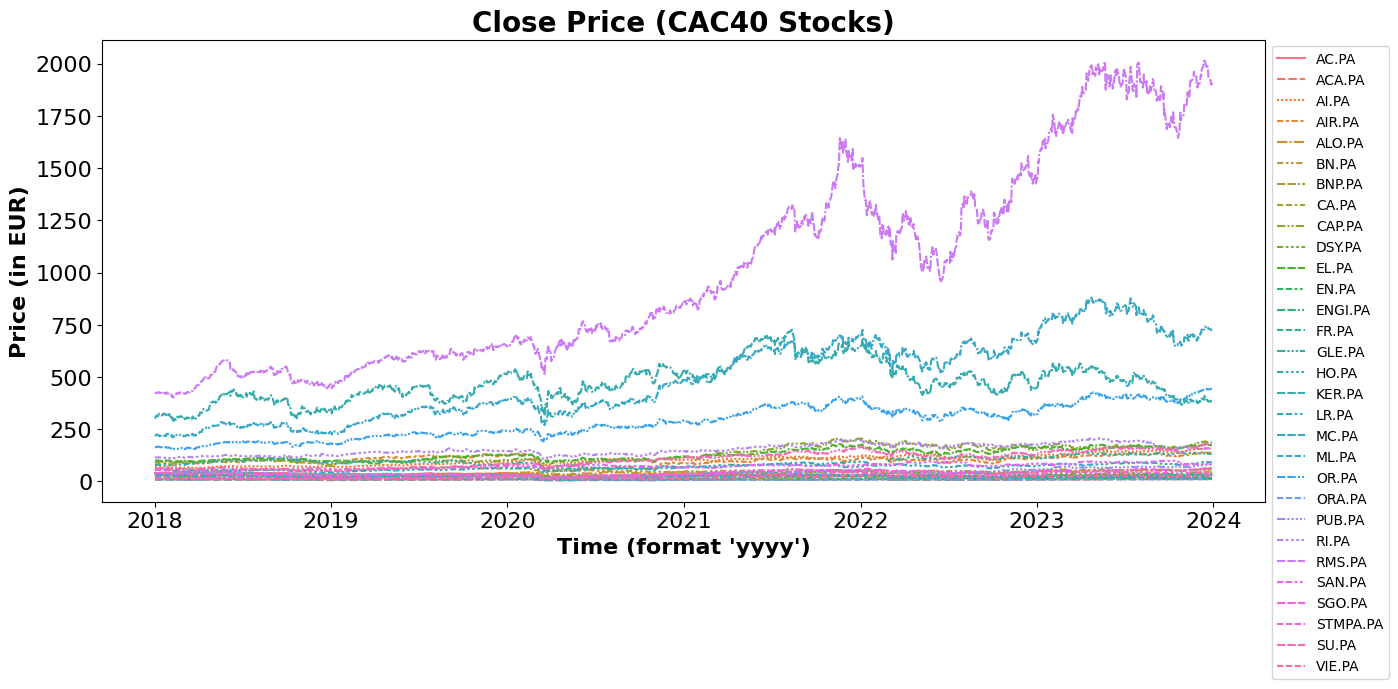

In [48]:
plot_times_series(data['Adj Close'])

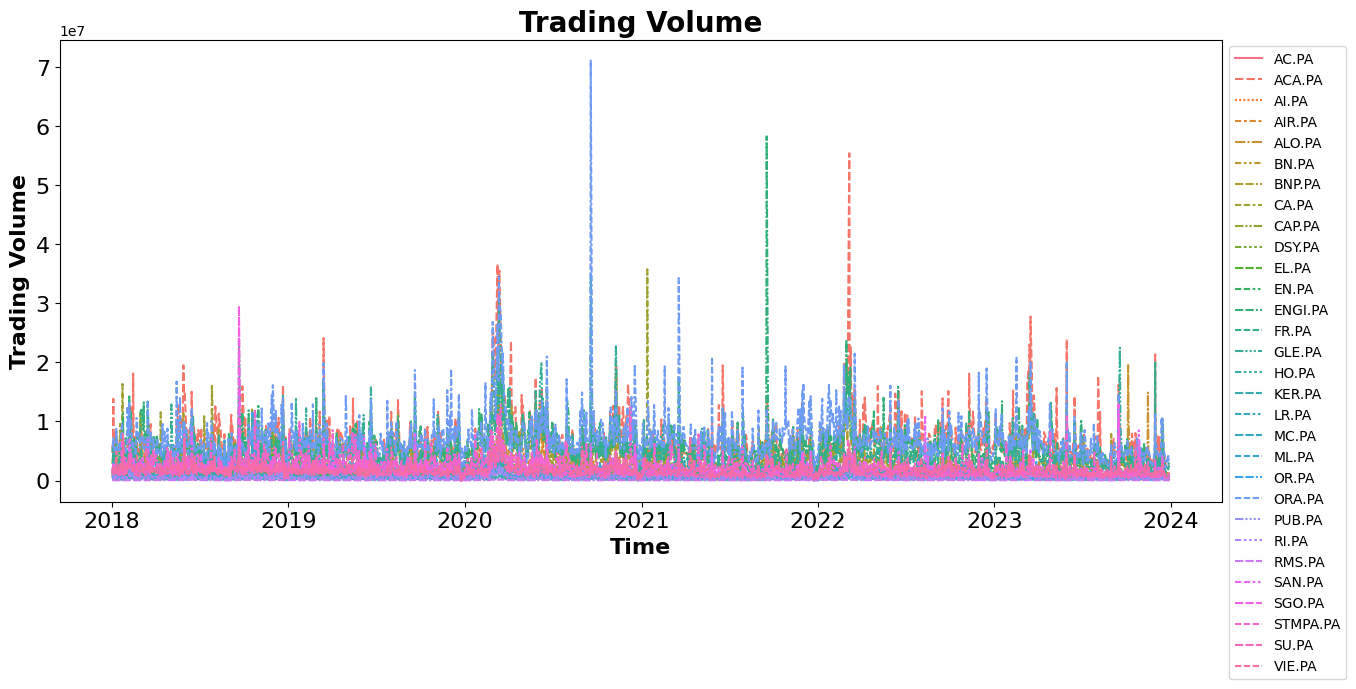

In [49]:
plot_trading_volumes(data['Volume'])

In [50]:
returns = data['Adj Close'].pct_change().dropna()
correlation_matrix = returns.corr()
correlation_matrix

Ticker,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,DSY.PA,...,OR.PA,ORA.PA,PUB.PA,RI.PA,RMS.PA,SAN.PA,SGO.PA,STMPA.PA,SU.PA,VIE.PA
Ticker,,,,,,,,,,,,,,,,,,,,,
AC.PA,1.000000,0.624212,0.390209,0.676782,0.355421,0.316970,0.629834,0.259378,0.468834,0.278106,...,0.355822,0.311939,0.485111,0.410815,0.394524,0.189882,0.528268,0.440400,0.496618,0.494808
ACA.PA,0.624212,1.000000,0.474039,0.602808,0.391981,0.329895,0.877714,0.334556,0.480663,0.261272,...,0.374140,0.415458,0.527005,0.354380,0.378597,0.199428,0.648546,0.482414,0.572410,0.522123
AI.PA,0.390209,0.474039,1.000000,0.458361,0.364076,0.470670,0.465168,0.332811,0.495890,0.450373,...,0.580845,0.434169,0.391254,0.471490,0.545429,0.371717,0.549615,0.497649,0.652442,0.504081
AIR.PA,0.676782,0.602808,0.458361,1.000000,0.379415,0.332264,0.618780,0.225661,0.504294,0.300032,...,0.377489,0.288465,0.429831,0.404318,0.442789,0.209021,0.530702,0.453504,0.534800,0.499226
ALO.PA,0.355421,0.391981,0.364076,0.379415,1.000000,0.227798,0.418951,0.177847,0.345228,0.231972,...,0.288037,0.209587,0.295172,0.288411,0.317991,0.160851,0.445304,0.348900,0.435659,0.367433
BN.PA,0.316970,0.329895,0.470670,0.332264,0.227798,1.000000,0.341785,0.341440,0.290773,0.210923,...,0.461827,0.416741,0.306532,0.463001,0.285494,0.390219,0.335745,0.237977,0.365767,0.440950
BNP.PA,0.629834,0.877714,0.465168,0.618780,0.418951,0.341785,1.000000,0.332605,0.463505,0.223760,...,0.381968,0.396829,0.529894,0.362802,0.379035,0.210214,0.650326,0.471622,0.578515,0.526160
CA.PA,0.259378,0.334556,0.332811,0.225661,0.177847,0.341440,0.332605,1.000000,0.140375,0.076465,...,0.221676,0.384259,0.279132,0.178197,0.117071,0.207434,0.298912,0.173182,0.283056,0.270530
CAP.PA,0.468834,0.480663,0.495890,0.504294,0.345228,0.290773,0.463505,0.140375,1.000000,0.609291,...,0.450187,0.214313,0.388176,0.437726,0.518633,0.221520,0.536677,0.575712,0.588900,0.488386


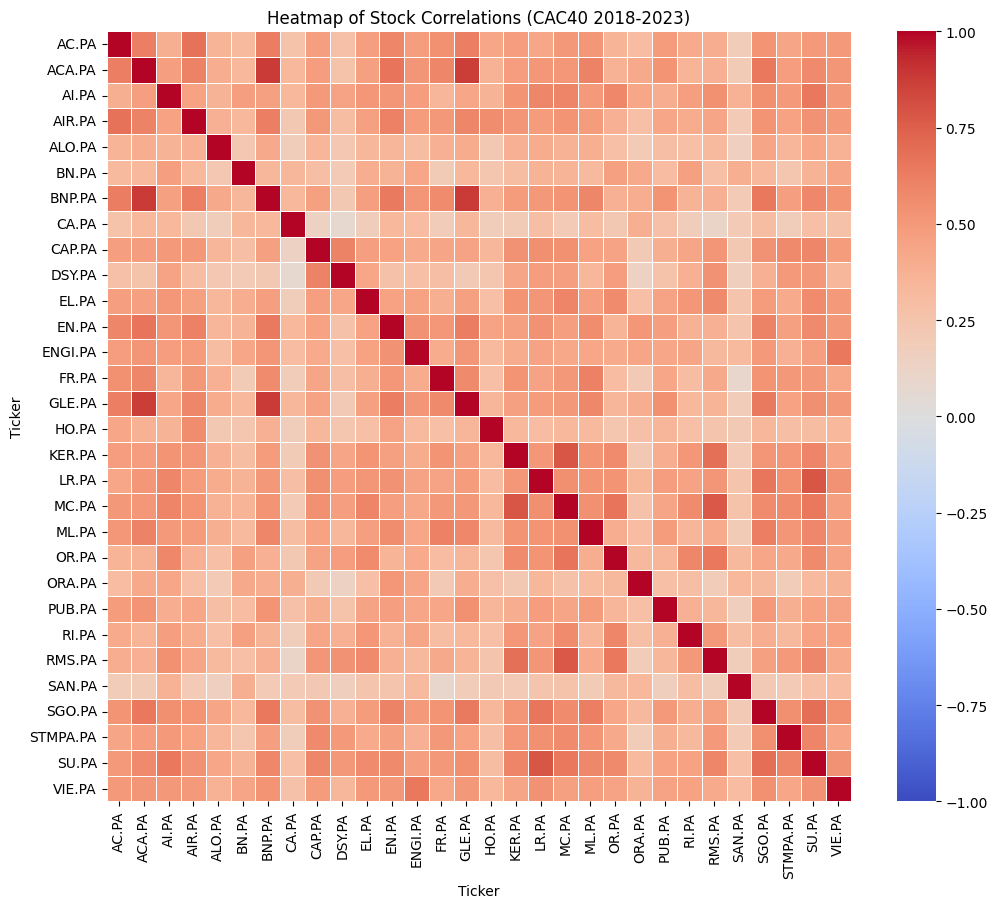

In [51]:
plot_heatmap(correlation_matrix, "Heatmap of Stock Correlations (CAC40 2018-2023)")

Based on the heatmap of CAC40 stock correlations (above), here are some observations:
- Strong Positive Correlations: 
    - Most stocks show positive correlations, with warmer colors (red tones) indicating relatively high correlations between certain stock pairs.
- Lower or Mixed Correlations: 
    - There are a few areas with lighter colors, which suggest weaker correlations between some pairs of stocks. 
    - It suggests a degree of diversification within the CAC40, meaning that not all stocks move in the same direction, which can reduce the overall volatility of the index.
- Negative Correlations: 
    - There are very few negative correlations (blue tones), indicating that it’s rare for two CAC40 stocks to move in opposite directions consistently.

Remark : The diagonal (Darker Regions - High Correlations) shows a perfect correlation (value of 1) for each stock with itself, which is expected.

In [52]:
stronger_corr(correlation_matrix)

Top 10 strongest correlations:
Ticker  Ticker
BNP.PA  GLE.PA    0.881164
GLE.PA  BNP.PA    0.881164
BNP.PA  ACA.PA    0.877714
ACA.PA  BNP.PA    0.877714
        GLE.PA    0.871025
GLE.PA  ACA.PA    0.871025
MC.PA   KER.PA    0.788303
KER.PA  MC.PA     0.788303
LR.PA   SU.PA     0.787485
SU.PA   LR.PA     0.787485
dtype: float64


Observations : 
- The pairs with the highest correlations are BNP Paribas (BNP.PA), Société Générale (GLE.PA), and Crédit Agricole (ACA.PA), which are all major financial institutions in France. These high correlations suggest that these banks tend to move similarly in response to market conditions, likely due to their shared exposure to economic factors that affect the banking sector, such as interest rates, regulatory changes, and economic cycles.
- Strong Correlations in Luxury Sector: LVMH (MC.PA) and Kering (KER.PA) show a high correlation of 0.788. They are influenced by similar market factors including consumer demand trends and economic conditions.

In [53]:
print("Measures :")
print("Minimum =", np.amin(np.array(correlation_matrix)))
print("Maximum =", np.amax(np.array(correlation_matrix)))
print("Range =", np.ptp(np.array(correlation_matrix)))
print("Variance =", np.var(np.array(correlation_matrix)))
print("Standard Deviation =", np.std(np.array(correlation_matrix)))
print("Mean =", np.mean(np.array(correlation_matrix)))
print("Median =", np.median(np.array(correlation_matrix)))
print("First Quartile =", np.quantile(np.array(correlation_matrix), 0.25))
print("Second Quartile =", np.quantile(np.array(correlation_matrix), 0.50))
print("Third Quartile =", np.quantile(np.array(correlation_matrix), 0.75))

Measures :
Minimum = 0.07646461597830519
Maximum = 1.0
Range = 0.9235353840216948
Variance = 0.028143595402508822
Standard Deviation = 0.16776052993034096
Mean = 0.44262639453502234
Median = 0.4414021796640458
First Quartile = 0.3326052403032034
Second Quartile = 0.4414021796640458
Third Quartile = 0.5228343451890489


Summary of Central Tendency and Dispersion : 
- Measures of Central Tendency: 
    - On average, there is a moderate positive correlation among the stocks in the CAC40 index (Mean - Average Correlation: 0.4426).
    - Q1 : 25% of the correlations are below this value, suggesting that a significant portion of stock pairs have lower correlations.
    - Q2 : The median (0.4414) is very close to the mean, suggesting a relatively symmetrical distribution of correlations around the central values.
    - Q3 : 75% of the correlations are below this level, indicating that only 25% of stock pairs exhibit correlations above 0.5228, showing stronger relationships between a minority of stocks.
- Measures of Dispersion:
    - Minimum Correlation: 0.0765
    - Maximum Correlation: 1.0 (useless infos - each stock is perfectly correlated with itself here).
    - Variance (0.0281) is relatively low, indicating that the correlation values do not vary too widely around the mean.
    - Standard Deviation (0.1678) suggests that most correlation values are moderately spread around the mean.


<a id="3c"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">The Stock Network<br></div>

<a id="3c1"></a>
### <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:110%; text-align:left; padding:3.0px; background: #7CA7FF; border-bottom: 8px solid #80ffff">2D representation</div>

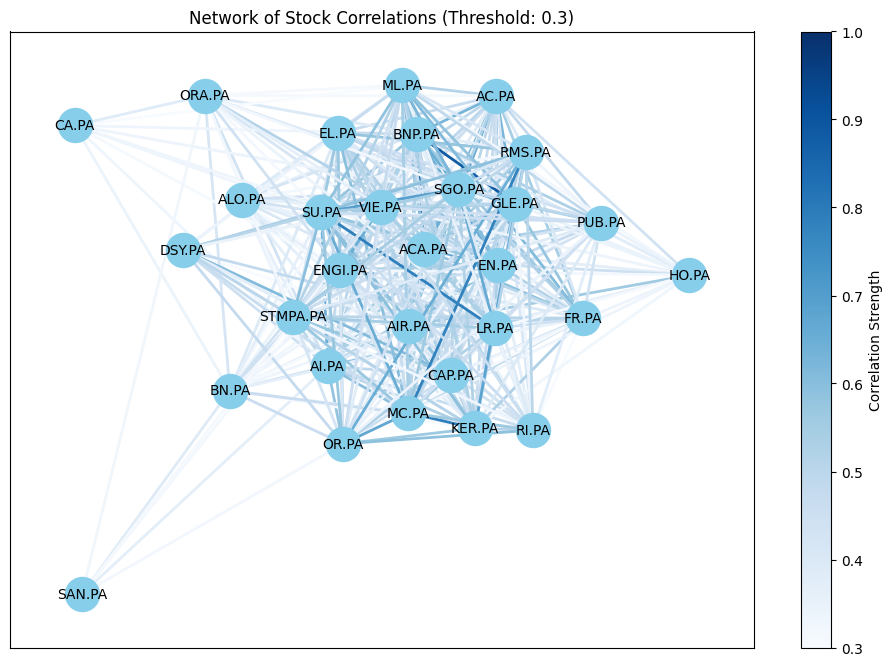

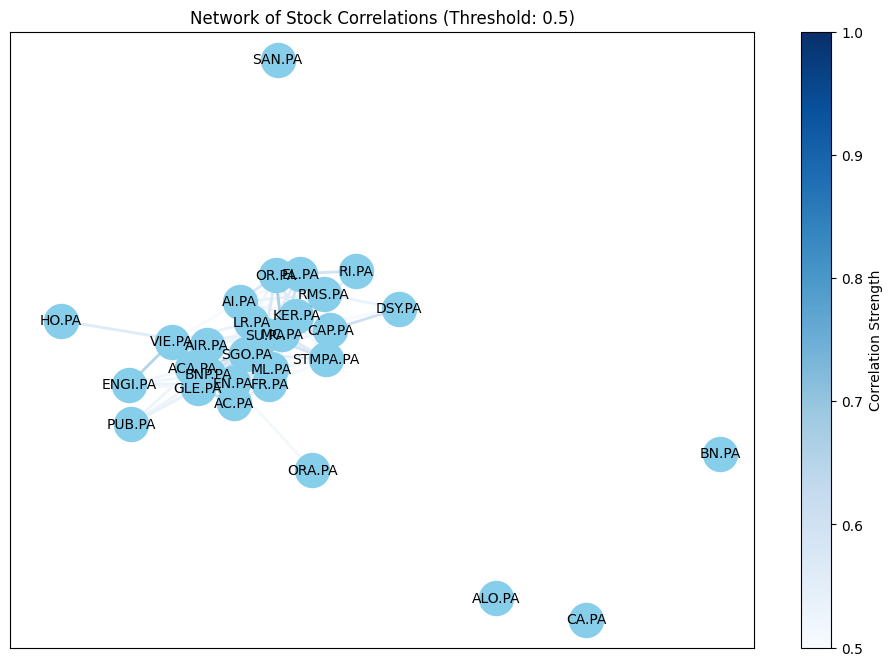

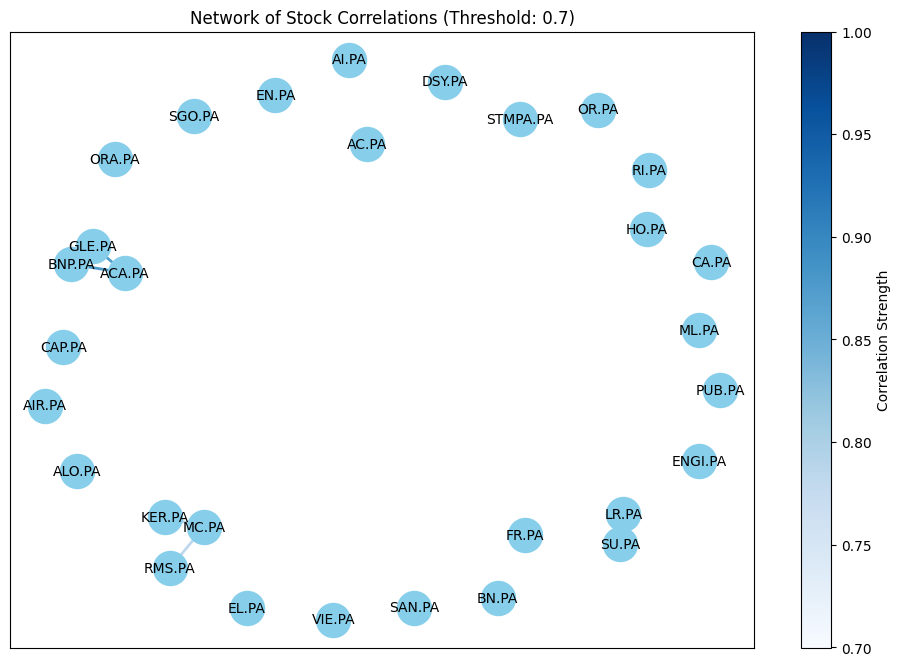

In [54]:
thresholds = [0.3, 0.5, 0.7]
graphs = []
for threshold in thresholds:
    G = create_correlation_network(correlation_matrix, threshold)
    graphs.append(G)
    visualize_correlation_network(G, threshold=threshold, node_size=600, edge_vmin=threshold)

<a id="3c2"></a>
### <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:110%; text-align:left; padding:3.0px; background: #7CA7FF; border-bottom: 8px solid #80ffff">3D representation</div>

3D representation of the Stock Network (uncomment the two lines below): 

![Logo de mon site](3D_network_stock_corr.png)

In [55]:
#Please uncomment these two lines and open the .html file in your browser to view the representation.
#visualize_correlation_network_3d(graphs[1], threshold=0.5, node_size=6)

<a id="3d"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Network Analysis<br></div>

<a id="3d1"></a>
### <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:110%; text-align:left; padding:3.0px; background: #7CA7FF; border-bottom: 8px solid #80ffff">Network Metrics Analysis</div>

#### 1. Assortativity and Transitivity : 

The two metrics:
- Assortativity is a measure of a network's tendency for nodes with similar degrees to connect to each other.
- Transitivity is a measure of the likelihood that two neighbors of a node are also connected to each other, reflecting the network's tendency to form tightly-knit clusters or triangles.

In [56]:
for i, G in enumerate(graphs):
    transitivity = nx.transitivity(G)
    assortativity = nx.degree_pearson_correlation_coefficient(G)
    print(f"Threshold = {thresholds[i]}")
    print(f"Network Transitivity: {transitivity:.4f}")
    print(f"Network Assortativity: {assortativity:.4f}\n")

Threshold = 0.3
Network Transitivity: 0.8957
Network Assortativity: -0.1183

Threshold = 0.5
Network Transitivity: 0.6573
Network Assortativity: -0.1053

Threshold = 0.7
Network Transitivity: 0.7500
Network Assortativity: 0.2500



Analysis on those results: 
- Threshold 0.3: High transitivity (0.8957) and negative assortativity (-0.1183) indicate a clustered, hub-like network where highly connected nodes link to less connected ones.
- Threshold 0.5: Both transitivity (0.6573) and assortativity (-0.1053) decrease, suggesting fewer clusters and a slightly weaker hub structure.
- Threshold 0.7: Transitivity rises again to 0.7500 with positive assortativity (0.2500), indicating small, tightly-knit clusters where nodes tend to connect to others with similar degrees.

#### 2. Degree Metrics and Clustering Coefficient :

The two metrics :
- <b>Degree</b>: Represents the number of direct connections each stock has with other stocks in the network, indicating nodes with high market influence.
- <b>Clustering Coefficient</b>: shows the level to which nodes tend to cluster together, uncovering subgroups in the network.

In [57]:
metrics_dfs = []
for i, G in enumerate(graphs):
    degrees = dict(G.degree())
    clustering_coeffs = nx.clustering(G)
    
    metrics_df = pd.DataFrame({
        'Node': list(degrees.keys()),
        'Degree': list(degrees.values()),
        'Clustering Coefficient': [clustering_coeffs[node] for node in degrees.keys()]
    }).sort_values(by="Degree", ascending=False)
    
    metrics_dfs.append((thresholds[i], metrics_df))

metrics_dfs[0][1]

,Node,Degree,Clustering Coefficient
2,AI.PA,29,0.795567
29,VIE.PA,28,0.833333
19,ML.PA,28,0.841270
12,ENGI.PA,28,0.817460
14,GLE.PA,27,0.866097
26,SGO.PA,27,0.883191
6,BNP.PA,27,0.866097
17,LR.PA,27,0.883191
11,EN.PA,27,0.866097
1,ACA.PA,27,0.866097


Analysis of the results <b>metrics_dfs[0]</b> (threshold = 0.3):
- Stocks like AI.PA, VIE.PA, and ML.PA have the highest connections, suggesting they are central influencers in the network, capable of affecting multiple stocks.
- Stocks such as ALO.PA, HO.PA, and DSY.PA show perfect clustering (1.0), indicating they form tightly-knit groups. Despite having fewer connections, they are highly interconnected within their clusters.
- Stocks with both high degree and high clustering, like BNP.PA and SGO.PA, likely act as leaders in specific subgroups, maintaining cohesion within those sections of the network.
- Stocks with moderate degrees but high clustering, such as PUB.PA and RI.PA, may play key roles within smaller, well-defined clusters rather than influencing the broader network.

In [58]:
metrics_dfs[2][1]

,Node,Degree,Clustering Coefficient
1,ACA.PA,2,1.0
14,GLE.PA,2,1.0
18,MC.PA,2,0.0
6,BNP.PA,2,1.0
16,KER.PA,1,0.0
28,SU.PA,1,0.0
24,RMS.PA,1,0.0
17,LR.PA,1,0.0
20,OR.PA,0,0.0
19,ML.PA,0,0.0


Analysis of the results <b>metrics_dfs[2]</b> (threshold = 0.7):
- Most stocks have a degree of 0, meaning they lack connections at this threshold. This suggests a largely disconnected network where most stocks don’t meet the correlation required for linkage.
- Only a few stocks, such as ACA.PA, GLE.PA, and BNP.PA, have limited connections (degree of 2), potentially signifying small, tightly correlated clusters within an otherwise sparse network.
- Most stocks with a degree of 0 also have a clustering coefficient of 0.0, marking them as entirely isolated.

In [59]:
avg_degrees = []
avg_clustering_coeffs = []

for i, G in enumerate(graphs):
    degrees = dict(G.degree())
    clustering_coeffs = nx.clustering(G)
    
    avg_degree = np.mean(list(degrees.values()))
    avg_clustering_coeff = np.mean(list(clustering_coeffs.values()))
    
    avg_degrees.append(avg_degree)
    avg_clustering_coeffs.append(avg_clustering_coeff)
    
    print(f"Threshold = {thresholds[i]}")
    print(f"Average Degree for the Network = {avg_degree:.4f}")
    print(f"Average Clustering Coefficient for the Network = {avg_clustering_coeff:.4f}\n")

Threshold = 0.3
Average Degree for the Network = 23.4667
Average Clustering Coefficient for the Network = 0.9114

Threshold = 0.5
Average Degree for the Network = 8.7333
Average Clustering Coefficient for the Network = 0.6047

Threshold = 0.7
Average Degree for the Network = 0.4000
Average Clustering Coefficient for the Network = 0.1000



As the threshold increases:
- Average Degree: Drops significantly from 23.47 at <b>0.3</b> to 0.4 at <b>0.7</b>, indicating fewer connections as only stronger correlations are retained.
- Average Clustering Coefficient: Decreases from 0.9114 at <b>0.3</b> to 0.1 at <b>0.7</b>, showing that higher thresholds break down the network’s tightly-knit clusters.

#### 3. Density Metrics :

Reflects how interconnected the stocks are, with higher values indicating more connections.

In [60]:
for i, G in enumerate(graphs):
    density = nx.density(G)
    print(f"Threshold = {thresholds[i]}")
    print(f"Network Density (Connectivity level of the graph): Density = {density:.4f}\n")

Threshold = 0.3
Network Density (Connectivity level of the graph): Density = 0.8092

Threshold = 0.5
Network Density (Connectivity level of the graph): Density = 0.3011

Threshold = 0.7
Network Density (Connectivity level of the graph): Density = 0.0138



As the threshold increases:
- Density at 0.3 (0.8092): The network is highly connected, with most possible connections present.
- Density at 0.5 (0.3011): Connectivity drops, retaining fewer but still significant links.
- Density at 0.7 (0.0138): The network is nearly disconnected, with only minimal connections.

#### 4. Average Path Length and Diameter Metric

Measures the average shortest path and the maximum shortest path in the network, highlighting how quickly information could spread.

In [61]:
for i, G in enumerate(graphs):
    print(f"Threshold = {thresholds[i]}")
    
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
        print("Average Path Length and Diameter (Reachability across the network):")
        print(f"   - Average Path Length = {avg_path_length:.4f}")
        print(f"   - Diameter = {diameter}\n")
    else:
        print("The network is not connected, so average path length and diameter cannot be computed.\n")

Threshold = 0.3
Average Path Length and Diameter (Reachability across the network):
   - Average Path Length = 1.1908
   - Diameter = 2

Threshold = 0.5
The network is not connected, so average path length and diameter cannot be computed.

Threshold = 0.7
The network is not connected, so average path length and diameter cannot be computed.



As the threshold increases:
- Threshold 0.3: The network is well-connected, with a short average path length (1.1908) and a small diameter (2), indicating efficient reachability across nodes.
- Thresholds 0.5 and 0.7: The network becomes disconnected, making it impossible to compute the average path length and diameter, as connectivity diminishes.

<a id="3d2"></a>
### <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:110%; text-align:left; padding:3.0px; background: #7CA7FF; border-bottom: 8px solid #80ffff">Network Centrality Measures Analysis</div>

Explanation of Each Centrality Measure:
- Degree Centrality: Identifies nodes with the most direct connections, representing stocks with numerous relationships.
- Closeness Centrality: Highlights nodes that can quickly reach others through shortest paths, indicating stocks that can efficiently spread information.
- Betweenness Centrality: Shows nodes that serve as bridges within the network, linking different stock clusters.
- Eigenvector Centrality: Identifies influential nodes connected to other highly central nodes, emphasizing stocks with systemic influence.

In [62]:
centrality_metrics = []

for i, G in enumerate(graphs):
    degree_dict = nx.degree_centrality(G)
    closeness_dict = nx.closeness_centrality(G)
    betweenness_dict = nx.betweenness_centrality(G)
    eigenvector_dict = nx.eigenvector_centrality(G, max_iter=1000)
    
    metrics_df = pd.DataFrame({
        "Degree Centrality": pd.Series(degree_dict),
        "Closeness Centrality": pd.Series(closeness_dict),
        "Betweenness Centrality": pd.Series(betweenness_dict),
        "Eigenvector Centrality": pd.Series(eigenvector_dict)
    }).sort_values(by="Degree Centrality", ascending=False)
    
    centrality_metrics.append((thresholds[i], metrics_df))

centrality_metrics[0][1]

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
AI.PA,1.000000,1.000000,0.026049,0.207606
VIE.PA,0.965517,0.966667,0.018601,0.204931
ML.PA,0.965517,0.966667,0.013856,0.205893
ENGI.PA,0.965517,0.966667,0.021662,0.202950
GLE.PA,0.931034,0.935484,0.010291,0.201238
SGO.PA,0.931034,0.935484,0.007024,0.203218
BNP.PA,0.931034,0.935484,0.010291,0.201238
LR.PA,0.931034,0.935484,0.007024,0.203218
EN.PA,0.931034,0.935484,0.010291,0.201238
ACA.PA,0.931034,0.935484,0.010291,0.201238


In [63]:
centrality_metrics[1][1]

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
SU.PA,0.655172,0.695217,0.095568,3.120600e-01
MC.PA,0.620690,0.653083,0.078752,2.972265e-01
SGO.PA,0.551724,0.633874,0.027187,2.910180e-01
LR.PA,0.517241,0.598659,0.037498,2.574381e-01
ACA.PA,0.482759,0.598659,0.034854,2.475329e-01
BNP.PA,0.482759,0.598659,0.034854,2.475329e-01
EN.PA,0.482759,0.582479,0.077716,2.356780e-01
KER.PA,0.482759,0.552608,0.030204,2.294870e-01
GLE.PA,0.448276,0.582479,0.029063,2.282481e-01
AIR.PA,0.413793,0.567151,0.068637,2.170349e-01


In [64]:
centrality_metrics[2][1]

,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality
ACA.PA,0.068966,0.068966,0.000000,5.773503e-01
GLE.PA,0.068966,0.068966,0.000000,5.773503e-01
MC.PA,0.068966,0.068966,0.002463,4.920169e-05
BNP.PA,0.068966,0.068966,0.000000,5.773503e-01
KER.PA,0.034483,0.045977,0.000000,3.479085e-05
SU.PA,0.034483,0.034483,0.000000,1.031393e-08
RMS.PA,0.034483,0.045977,0.000000,3.479085e-05
LR.PA,0.034483,0.034483,0.000000,1.031393e-08
OR.PA,0.000000,0.000000,0.000000,5.862788e-22
ML.PA,0.000000,0.000000,0.000000,5.862788e-22


- Threshold 0.3:
    - High Connectivity: Stocks like AI.PA, VIE.PA, and ML.PA have high degree and closeness centralities, indicating they are central in direct connections and information reachability.
    - Betweenness and Eigenvector Centralities: Relatively low, suggesting fewer bridging nodes, though certain stocks like AI.PA and ENGI.PA maintain influence in subgroups.

- Threshold 0.5:
    - Reduced Centrality: Connectivity drops, with stocks such as SU.PA and MC.PA maintaining higher centralities, indicating they remain influential within a more fragmented network.
    - Eigenvector Centrality: Concentrated in a few nodes like SGO.PA, suggesting reliance on fewer influential nodes.

- Threshold 0.7:
    - Minimal Connectivity: Most nodes have centrality scores near zero, reflecting an almost entirely disconnected network.
    - Degree and Eigenvector Centralities: Limited to a few nodes like ACA.PA and GLE.PA, indicating only isolated, minor influence.

<a id="3e"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Analysis on Network Models application (Erdős–Rényi and Barabási–Albert)<br></div>

Explanation :
- Erdős–Rényi Model:
    - Generates a random graph using the calculated probability p based on the stock network’s edge density.
    - Provides a baseline for comparison, assessing if the stock network has more clustering than a random configuration.
- Barabási–Albert Model:
    - Generates a scale-free, hub-based network where a few nodes have many connections, which is common in financial networks.
    - Uses m based on the average connections per node in the stock network.
- Comparison Metrics:
    - Transitivity: Shows the clustering tendency in each model.
    - Assortativity: Indicates if nodes of similar degrees connect.

In [65]:
data = []
for i, G in enumerate(graphs):
    num_nodes = len(G.nodes())
    num_edges = len(G.edges())

    #Erdős–Rényi Model
    p = num_edges / (num_nodes * (num_nodes - 1) / 2)
    er_graph = nx.erdos_renyi_graph(num_nodes, p)
    
    #Barabási–Albert Model
    m = max(1, num_edges // num_nodes)
    ba_graph = nx.barabasi_albert_graph(num_nodes, m)

    data.append({
        "Threshold": thresholds[i],
        "Network": "Stock Network",
        "Transitivity": nx.transitivity(G),
        "Assortativity": nx.degree_pearson_correlation_coefficient(G)
    })
    data.append({
        "Threshold": thresholds[i],
        "Network": "Erdős-Rényi Model",
        "Transitivity": nx.transitivity(er_graph),
        "Assortativity": nx.degree_pearson_correlation_coefficient(er_graph)
    })
    data.append({
        "Threshold": thresholds[i],
        "Network": "Barabási-Albert Model",
        "Transitivity": nx.transitivity(ba_graph),
        "Assortativity": nx.degree_pearson_correlation_coefficient(ba_graph)
    })

metrics_df = pd.DataFrame(data)
metrics_df


,Threshold,Network,Transitivity,Assortativity
0,0.3,Stock Network,0.895699,-0.118258
1,0.3,Erdős-Rényi Model,0.783486,-0.051355
2,0.3,Barabási-Albert Model,0.560334,-0.261071
3,0.5,Stock Network,0.657315,-0.105256
4,0.5,Erdős-Rényi Model,0.238636,-0.055175
5,0.5,Barabási-Albert Model,0.297872,-0.255660
6,0.7,Stock Network,0.750000,0.250000
7,0.7,Erdős-Rényi Model,0.000000,-0.296296
8,0.7,Barabási-Albert Model,0.000000,-0.381744


As the threshold increases, the Stock Network keeps high clustering (transitivity) and shifts to positive assortativity, meaning stocks tend to group into tight clusters and connect with similar stocks.

In contrast, the Erdős–Rényi model remains mostly random, with little clustering, and the Barabási–Albert model forms a hub structure with a few highly connected nodes. This shows that the Stock Network has unique clustering patterns that don’t match either random or hub-based models.

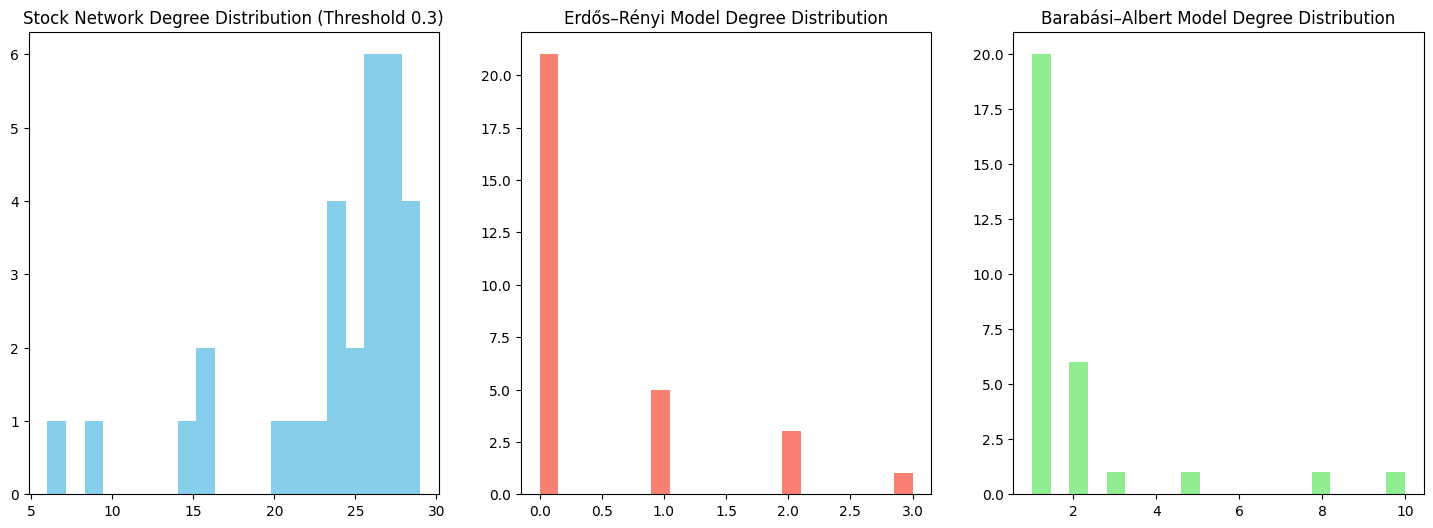

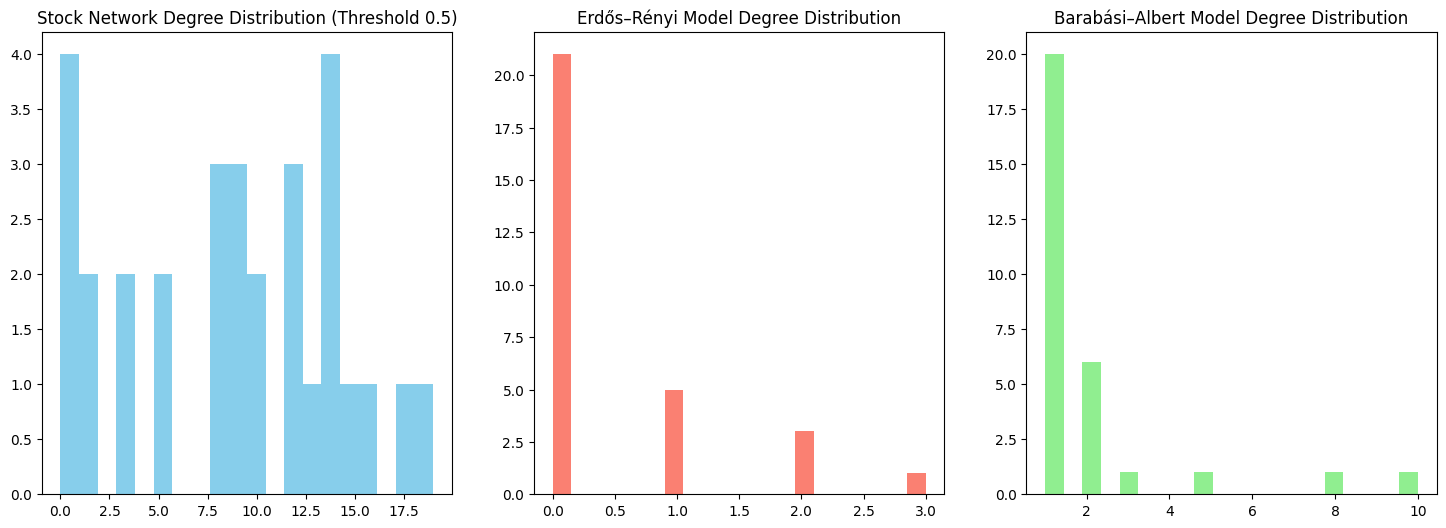

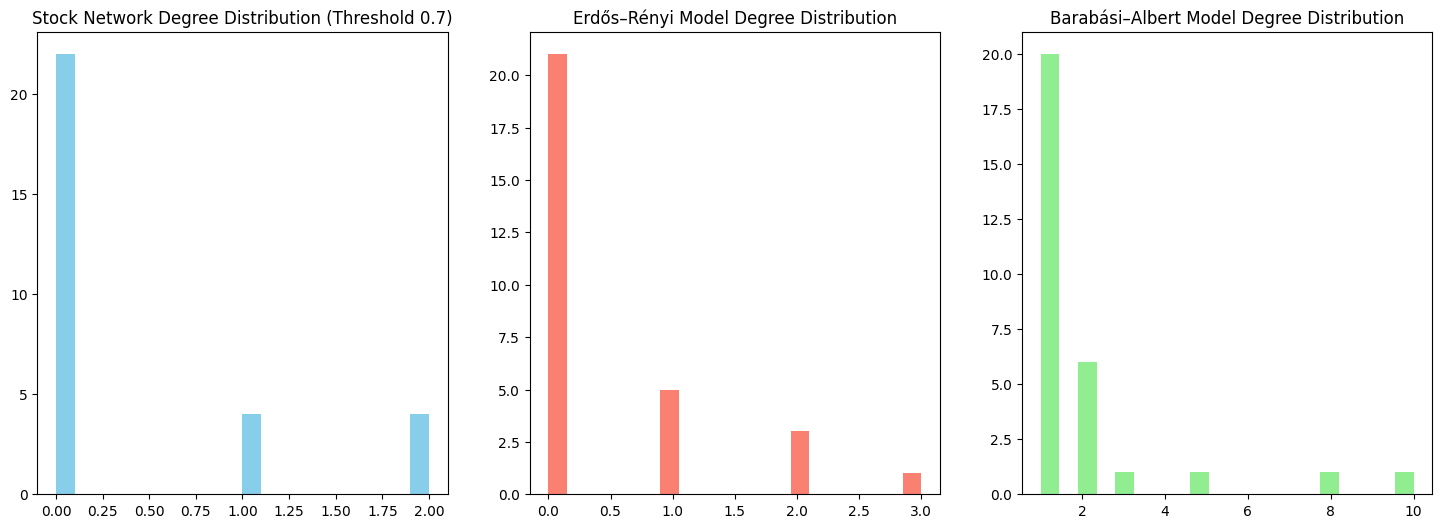

In [66]:
for i, G in enumerate(graphs):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    #Degree distribution of the stock network
    degree_sequence_stock = sorted([d for n, d in G.degree()], reverse=True)
    ax[0].hist(degree_sequence_stock, bins=20, color='skyblue')
    ax[0].set_title(f"Stock Network Degree Distribution (Threshold {thresholds[i]})")

    #Degree distribution of the Erdős–Rényi model
    degree_sequence_er = sorted([d for n, d in er_graph.degree()], reverse=True)
    ax[1].hist(degree_sequence_er, bins=20, color='salmon')
    ax[1].set_title("Erdős–Rényi Model Degree Distribution")

    #Degree distribution of the Barabási–Albert model
    degree_sequence_ba = sorted([d for n, d in ba_graph.degree()], reverse=True)
    ax[2].hist(degree_sequence_ba, bins=20, color='lightgreen')
    ax[2].set_title("Barabási–Albert Model Degree Distribution")

    plt.show()

As the threshold increases, the Stock Network becomes more sparse, with fewer and stronger connections. Unlike the Erdős–Rényi model, which has mostly low degrees, and the Barabási–Albert model, which forms hubs, the Stock Network moves from moderate clustering to very few connections. This shows that the Stock Network has a unique structure not seen in the other models.

<a id="3f"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Meso-Scale Analysis (Community Detection and Core-Periphery)<br></div>

The meso-scale analysis in this example helps reveal the community structures and core-periphery dynamics within the stock network. By identifying clusters of closely related stocks (communities), we can see potential sector-based groupings or shared market behaviors. Additionally, core-periphery analysis highlights which stocks are central to the network, offering insight into key players versus more isolated stocks, especially as correlation thresholds increase.

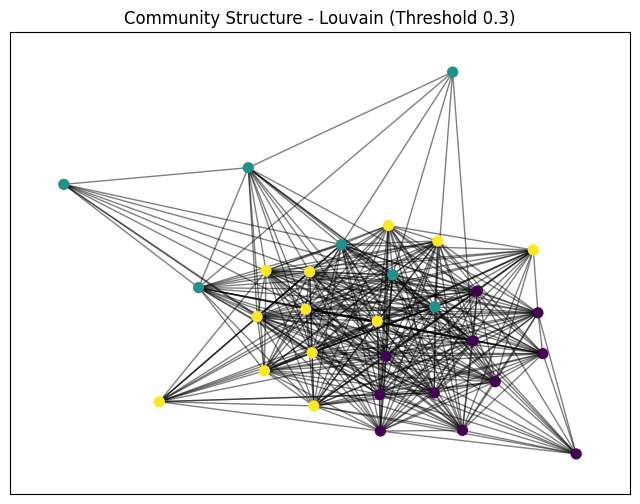

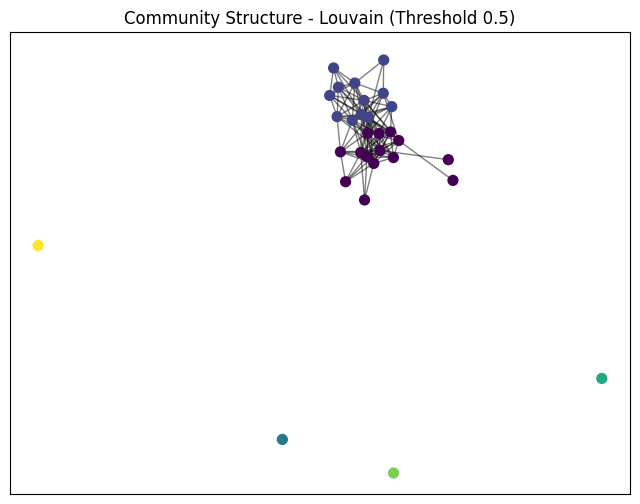

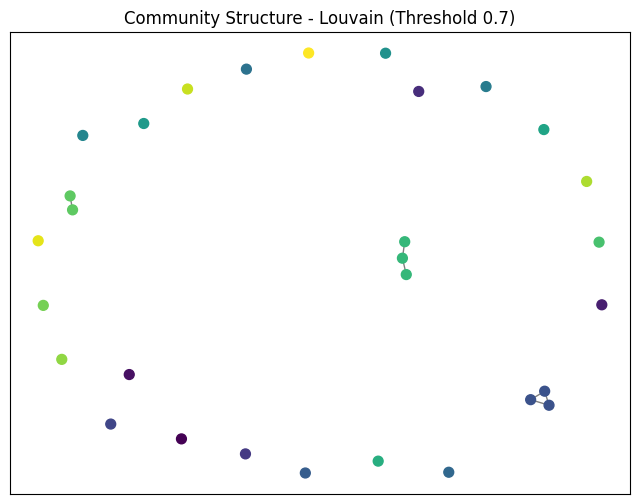

In [69]:
meso_data = []

for i, G in enumerate(graphs):
    threshold = thresholds[i]
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    
    # Visualize the community structure
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    cmap = plt.get_cmap("viridis", max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, node_size=50, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f"Community Structure - Louvain (Threshold {threshold})")
    plt.show()

    core_numbers = nx.core_number(G)
    max_core = max(core_numbers.values())
    
    core_nodes = [node for node, core in core_numbers.items() if core == max_core]
    periphery_nodes = [node for node, core in core_numbers.items() if core < max_core]
    
    meso_data.append({
        "Threshold": threshold,
        "Modularity": modularity,
        "Core Size": len(core_nodes),
        "Periphery Size": len(periphery_nodes)
    })

meso_df = pd.DataFrame(meso_data)

In [70]:
meso_df

,Threshold,Modularity,Core Size,Periphery Size
0,0.3,0.059983,23,7
1,0.5,0.248113,11,19
2,0.7,0.597897,3,27


As the threshold increases, modularity grows from 0.06 at 0.3 to 0.60 at 0.7, meaning the communities become more distinct. The core size shrinks from 23 nodes at 0.3 to only 3 nodes at 0.7, showing that only a few stocks remain central as weaker links are removed. Meanwhile, the periphery size increases, with more stocks becoming isolated. This suggests that at higher thresholds, the network becomes sparse with a clear separation between core and peripheral stocks.

<a id="3h"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Portfolio Diversification<br></div>